# Stock price prediction using Transformer architecture
### SOTA:
Chineese model for predicting CSI 300 got RMSE of 110.6

Generally MAPE around 5-7% is good

SMAPE around 0.02-0.06


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

In [2]:
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.11.0


#### Data preprocessing

In [3]:
models_dir='./models/'

In [27]:
df = pd.read_csv('sp500.csv')

In [28]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('d').sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
df = df.fillna(method="ffill")

In [29]:
df = df.tail(10000).reset_index(drop=True)

In [30]:
df

,Date,Open,High,Low,Close,Volume
0,1995-08-08,560.03,561.53,558.32,560.39,1.700500e+08
1,1995-08-09,560.39,561.59,559.29,559.71,1.685500e+08
2,1995-08-10,559.71,560.63,556.05,557.45,1.703667e+08
3,1995-08-11,557.45,558.50,553.04,555.11,1.488056e+08
4,1995-08-12,557.45,558.50,553.04,555.11,1.488056e+08
...,...,...,...,...,...,...
9995,2022-12-19,3853.79,3854.86,3800.04,3817.66,2.294960e+09
9996,2022-12-20,3810.47,3838.24,3795.62,3821.62,2.223746e+09
9997,2022-12-21,3839.49,3889.82,3839.49,3878.44,2.145801e+09
9998,2022-12-22,3853.26,3853.26,3764.49,3822.39,2.363139e+09


In [31]:
columns = ['Open', 'High', 'Low', 'Close']
plot_cols = ['Open', 'High', 'Low', 'Close']

In [32]:
date_time = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [33]:
df = df[columns]

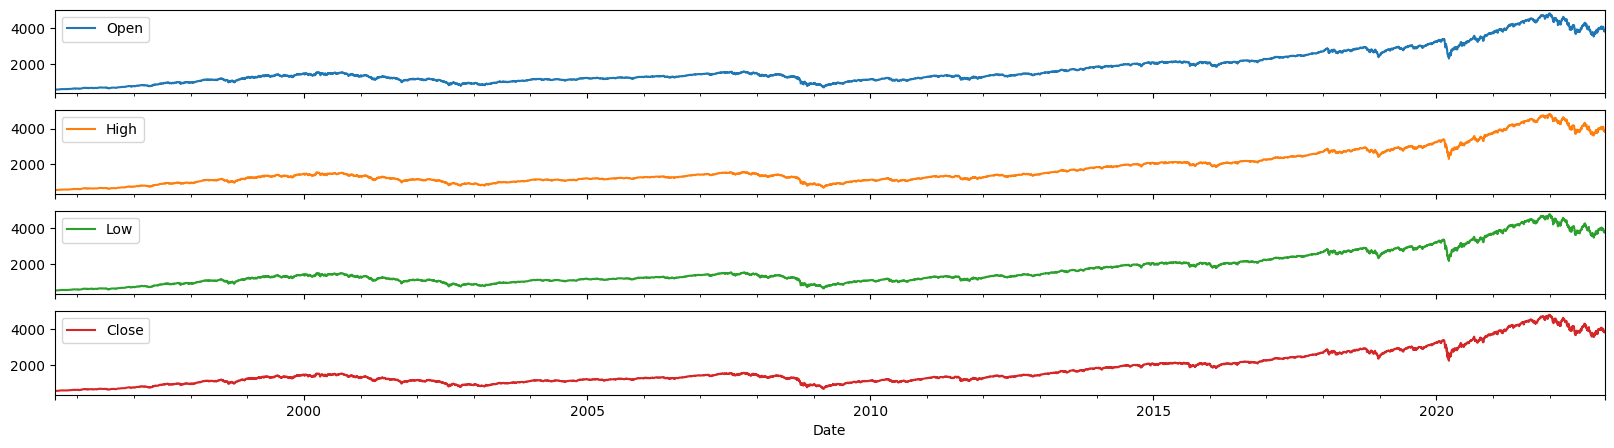

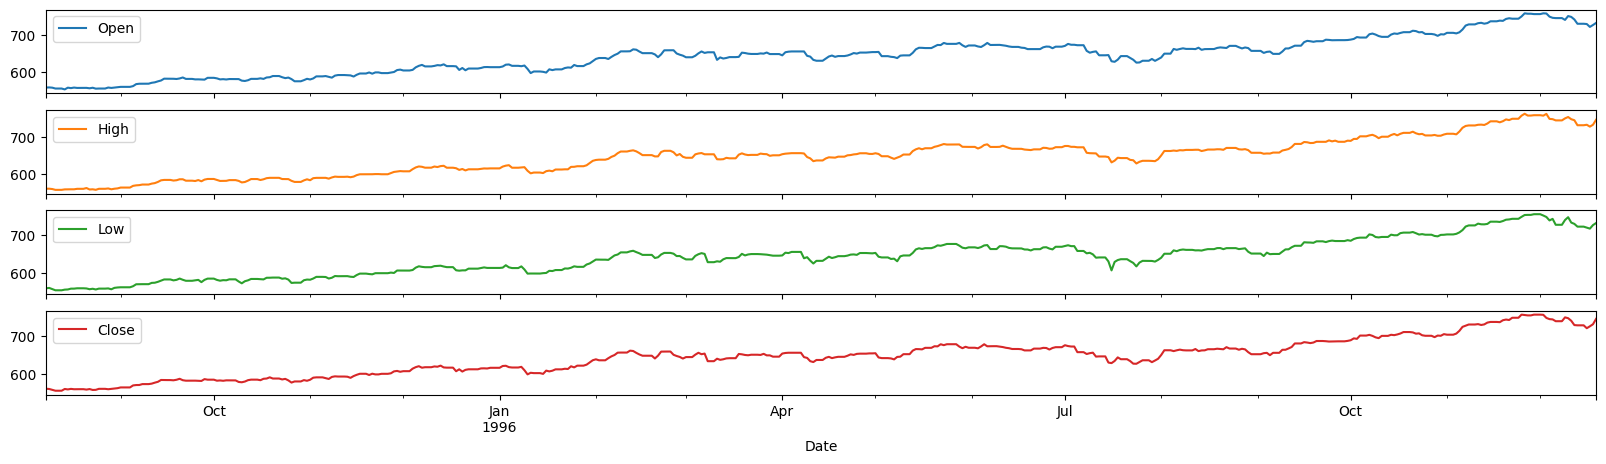

In [34]:
plot_cols = ['Open', 'High', 'Low', 'Close']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:500]
plot_features.index = date_time[:500]
_ = plot_features.plot(subplots=True)


#### Encoding time into sine and cosine of Weeks/Months/Years

In [35]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

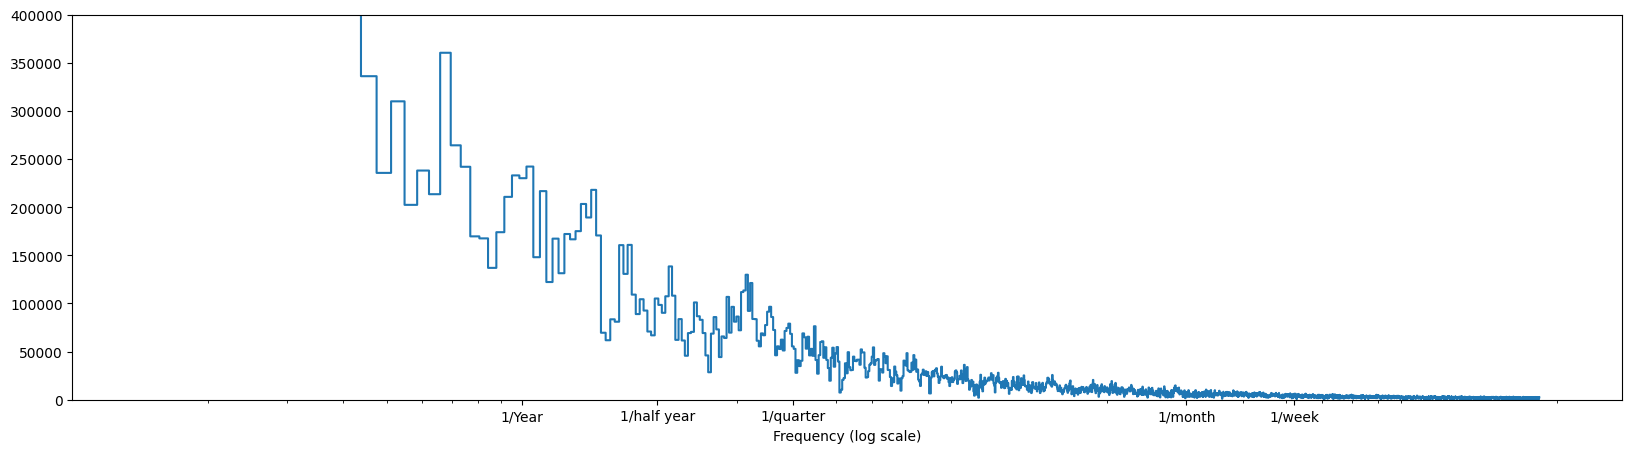

In [36]:
fft = tf.signal.rfft(df['High'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['High'])
days_per_year = 365.2524
years_per_dataset = n_samples_d/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 2, 4, 30, 365.2524/7], labels=['1/Year', '1/half year','1/quarter', '1/month', '1/week'])
_ = plt.xlabel('Frequency (log scale)')
plt.rcParams["figure.figsize"] = (20,5)
plt.show()


Fft shows no real key frequencies

In [37]:
day = 24*60*60
week = 7*day
month = 365.2425*day/12
year = (365.2425)*day

df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

C:\Users\Pawel\AppData\Local\Temp\ipykernel_14984\569351892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))


In [44]:
# plt.plot(np.array(df['Week sin'])[:30])
# plt.plot(np.array(df['Week cos'])[:30])
# plt.xlabel('Day')
# plt.title('Day of week')

#### Reimplementing Stratified Time Series Split

In [157]:
def get_indeces(train_steps=7,val_steps=2,test_steps=1,seq_length=10,data=np.array(range(100)).reshape(-1,1), column=3):
    curr_train_step=0
    curr_val_step=0
    curr_test_step=0
    print(data.shape)
    train_label_data = []
    train_input_data = []
    
    val_label_data = []
    val_input_data = []
    
    test_label_data = []
    test_input_data = []
    
    for i in range(data.shape[0]):
        if i+seq_length >=data.shape[0]:
            break
        if curr_train_step<train_steps:
            curr_train_step+=1
            # print('train',data[i:i+seq_length,:])
            # print('label',data[i+seq_length:i+seq_length+1,:])
            # print(data[i:i+seq_length,:].shape)
            train_input_data.append(data[i:i+seq_length,:])
            train_label_data.append(data[i+seq_length:i+seq_length+1,column])
        elif curr_train_step==train_steps:
            if curr_val_step<val_steps:
                curr_val_step+=1
                val_input_data.append(data[i:i+seq_length,:])
                val_label_data.append(data[i+seq_length:i+seq_length+1,column])
                # print('val',data[i:i+seq_length,:])
            elif curr_val_step==val_steps:
                if curr_test_step<test_steps:
                    curr_test_step+=1
                    # print('test',data[i:i+seq_length,:])
                    test_input_data.append(data[i:i+seq_length,:])
                    test_label_data.append(data[i+seq_length:i+seq_length+1,column])
                else:
                    curr_train_step=0
                    curr_val_step=0
                    curr_test_step=0
                    curr_train_step+=1
                    # print('train',data[i:i+seq_length,:])
                    train_input_data.append(data[i:i+seq_length,:])
                    train_label_data.append(data[i+seq_length:i+seq_length+1,column])
    train_label_data = np.array(train_label_data)
    train_input_data = np.array(train_input_data)
    
    val_label_data = np.array(val_label_data)
    val_input_data = np.array(val_input_data)
    
    test_label_data = np.array(test_label_data)
    test_input_data = np.array(test_input_data)
    
    return train_input_data, train_label_data, val_input_data, val_label_data, test_input_data, test_label_data

In [158]:
train_X, train_y, val_X, val_y, test_X, test_y = get_indeces(seq_length=60, data=np.array(df))

(10000, 10)


In [159]:
train_mean_x = train_X.mean(axis=0)
train_std_x = train_X.std(axis=0)

train_mean_y = train_y.mean(axis=0)
train_std_y = train_y.mean(axis=0)

In [160]:
train_X = (train_X - train_mean_x) / train_std_x
train_y = (train_y - train_mean_y) / train_std_y

val_X = (val_X - train_mean_x) / train_std_x
val_y = (val_y - train_mean_y) / train_std_y

test_X = (test_X - train_mean_x) / train_std_x
test_y = (test_y - train_mean_y) / train_std_y

#### Dividing data into train/test and scaling to normal distribution

In [45]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [46]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

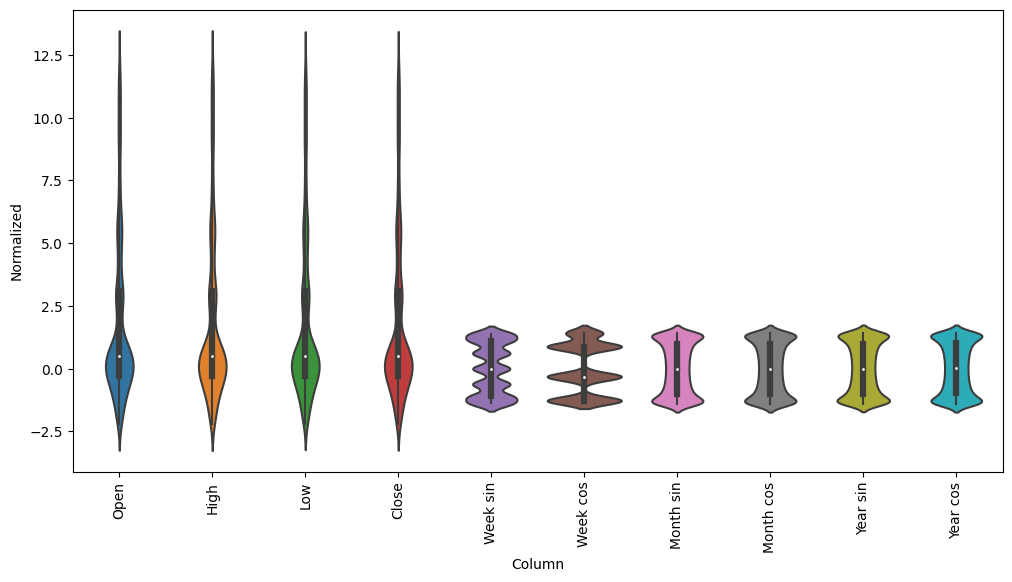

In [47]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

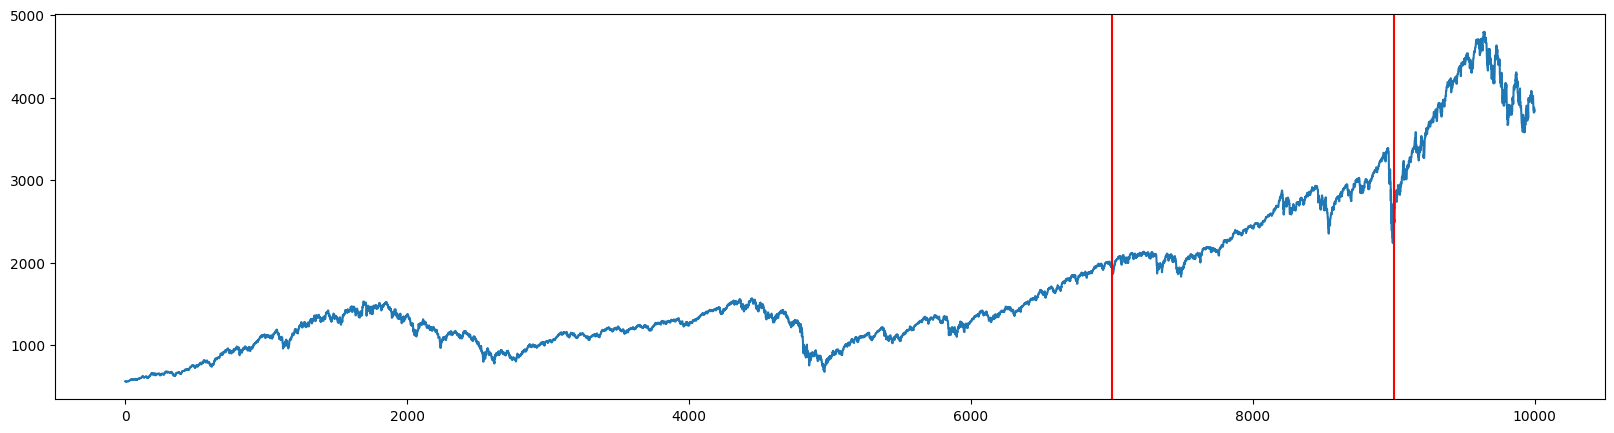

In [48]:
plt.plot(df['Close'])
plt.axvline(x = n*0.7, color = 'r', label = 'koniec train')
plt.axvline(x = n*0.9, color = 'r', label = 'koniec val')
plt.show()

#### Implementing the sliding window mechanism

In [49]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Close', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [d]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32, )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

#### Helper function for merging histories

In [56]:
def merge_histories(histories):
    metrics=list(histories[0].history.keys())
    new_history = {}
    for metric in metrics:
        new_history[metric] = []
    for history in histories:
        for metric in history.history.keys():
            new_history[metric] +=history.history[metric]
    return new_history

#### Transformer architecture

In [139]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [140]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="leaky_relu")(x)
    return tf.keras.Model(inputs, outputs)

In [50]:
wide_window = WindowGenerator(input_width=7, label_width=7, shift=1,
                     label_columns=['Close'])
wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['Close']

In [24]:
input_shape = wide_window.example[0].shape[1:]

## Baseline:
- train_loss: 17%
- train_rmse: 0.12

- val_loss: 14%
- val_rmse: 0.63

- test_loss: 9.5%
- test_rmse: 0.3

In [23]:
baseline = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [31]:
baseline.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

baseline_hist = baseline.fit(wide_window.train,
        epochs=200,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)

Epoch 1/200
44/44 [==============================] - 4s 21ms/step - loss: 25.8069 - root_mean_squared_error: 0.2323 - val_loss: 28.2311 - val_root_mean_squared_error: 1.1633
Epoch 2/200
44/44 [==============================] - 0s 7ms/step - loss: 25.7111 - root_mean_squared_error: 0.2310 - val_loss: 28.0845 - val_root_mean_squared_error: 1.1583
Epoch 3/200
44/44 [==============================] - 0s 9ms/step - loss: 25.4493 - root_mean_squared_error: 0.2293 - val_loss: 27.8369 - val_root_mean_squared_error: 1.1506
Epoch 4/200
44/44 [==============================] - 0s 7ms/step - loss: 25.4150 - root_mean_squared_error: 0.2277 - val_loss: 27.5703 - val_root_mean_squared_error: 1.1423
Epoch 5/200
44/44 [==============================] - 0s 9ms/step - loss: 25.2254 - root_mean_squared_error: 0.2259 - val_loss: 27.3079 - val_root_mean_squared_error: 1.1342
Epoch 6/200
44/44 [==============================] - 0s 7ms/step - loss: 25.0225 - root_mean_squared_error: 0.2246 - val_loss: 27.1154

In [34]:
baseline.save(models_dir + 'baseline.h5')

In [32]:
val_performance = baseline.evaluate(wide_window.val)
performance = baseline.evaluate(wide_window.test, verbose=0)

13/13 [==============================] - 0s 4ms/step - loss: 13.9495 - root_mean_squared_error: 0.6342


In [33]:
print("Val loss:", val_performance)
print("Test loss:", performance)

Val loss: [13.949492454528809, 0.6342176198959351]
Test loss: [9.481806755065918, 0.3033859133720398]


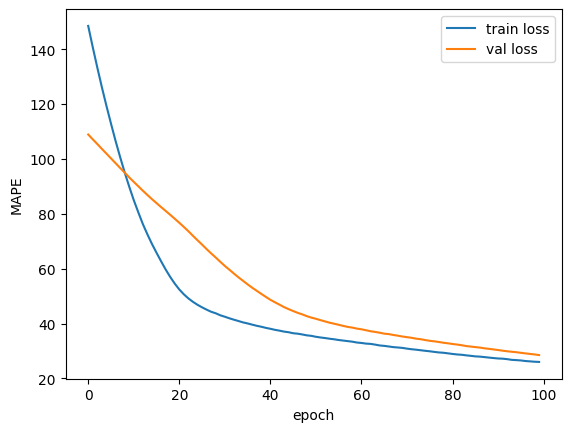

In [29]:
plt.plot(baseline_hist.history['loss'])
plt.plot(baseline_hist.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('epoch')
plt.ylabel('MAPE')
plt.show()

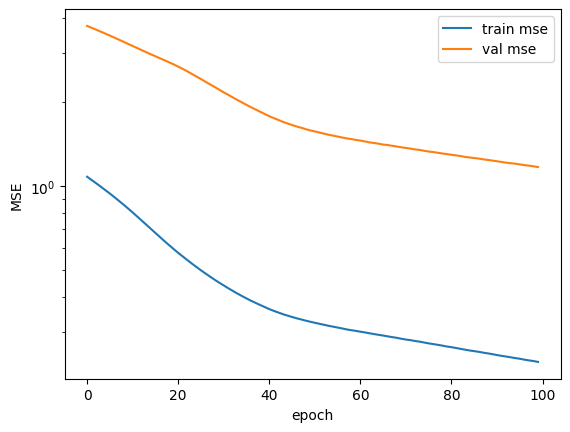

In [30]:
plt.plot(baseline_hist.history['root_mean_squared_error'])
plt.plot(baseline_hist.history['val_root_mean_squared_error'])
plt.legend(['train mse', 'val mse'])
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.show()

## Baseline Transformer
- train_loss: 23.6%
- train_rmse: 0.02

- val_loss: 13.6%
- val_rmse: 0.28

- test_loss: 7.6%
- test_rmse: 0.04

In [41]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [42]:
model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)
# model.summary()

In [26]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50, min_delta=0.1, restore_best_weights=True, start_from_epoch=10)]

In [157]:
history= model.fit(
    wide_window.train,
    epochs=2000,
    callbacks=callbacks,
    validation_data=wide_window.val,
    verbose=1
)

Epoch 1/2000
44/44 [==============================] - 11s 41ms/step - loss: 111.5774 - mean_squared_error: 1.0021 - val_loss: 102.9125 - val_mean_squared_error: 12.6172
Epoch 2/2000
44/44 [==============================] - 2s 36ms/step - loss: 106.8630 - mean_squared_error: 0.9993 - val_loss: 102.7250 - val_mean_squared_error: 12.5720
Epoch 3/2000
44/44 [==============================] - 2s 39ms/step - loss: 105.3353 - mean_squared_error: 0.9942 - val_loss: 102.6421 - val_mean_squared_error: 12.5502
Epoch 4/2000
44/44 [==============================] - 2s 36ms/step - loss: 106.2292 - mean_squared_error: 0.9910 - val_loss: 102.4820 - val_mean_squared_error: 12.5106
Epoch 5/2000
44/44 [==============================] - 2s 35ms/step - loss: 105.5713 - mean_squared_error: 0.9846 - val_loss: 102.1516 - val_mean_squared_error: 12.4307
Epoch 6/2000
44/44 [==============================] - 2s 36ms/step - loss: 105.0337 - mean_squared_error: 0.9668 - val_loss: 101.6689 - val_mean_squared_error:

In [158]:
model.evaluate(wide_window.test, verbose=1)

7/7 [==============================] - 0s 16ms/step - loss: 7.5962 - mean_squared_error: 0.0477


[7.596197605133057, 0.04768957570195198]

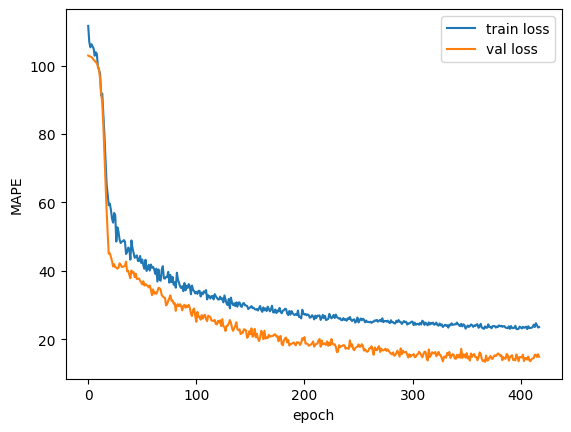

In [159]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('epoch')
plt.ylabel('MAPE')
plt.show()

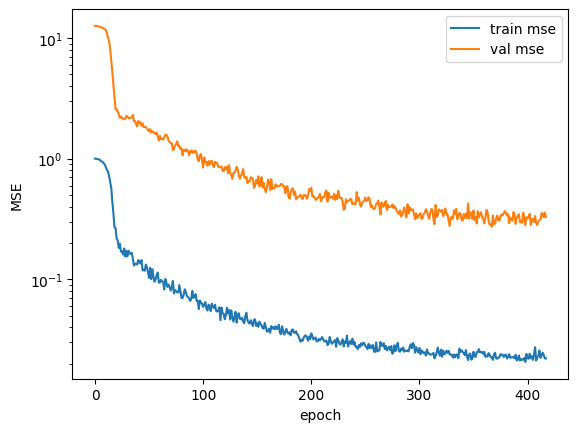

In [160]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['train mse', 'val mse'])
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.show()

In [46]:
model.save(models_dir + 'model_cross_val_10.h5')

## Different training technique
I used a simple TimeSeriesSplit from sklearn to fit the model with multiple steps

In [44]:
tscv = TimeSeriesSplit(n_splits=10, test_size=71)

#### Baseline transformer trained differently
- train_loss: 24%
- train_rmse: 0.13
- val_loss: 5.5%
- val_rmse: 0.13

In [45]:
history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=7, label_width=7, shift=1,
                     label_columns=['Close'])
    history= model.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)

Epoch 1/100
22/22 [==============================] - 15s 70ms/step - loss: 117.1066 - root_mean_squared_error: 0.8654 - val_loss: 105.3495 - val_root_mean_squared_error: 0.2248
Epoch 2/100
22/22 [==============================] - 1s 59ms/step - loss: 110.1255 - root_mean_squared_error: 0.8251 - val_loss: 120.2229 - val_root_mean_squared_error: 0.2143
Epoch 3/100
22/22 [==============================] - 1s 27ms/step - loss: 101.4641 - root_mean_squared_error: 0.7778 - val_loss: 148.4278 - val_root_mean_squared_error: 0.2025
Epoch 4/100
22/22 [==============================] - 1s 27ms/step - loss: 96.6357 - root_mean_squared_error: 0.7531 - val_loss: 193.2410 - val_root_mean_squared_error: 0.1890
Epoch 5/100
22/22 [==============================] - 1s 26ms/step - loss: 88.5872 - root_mean_squared_error: 0.7138 - val_loss: 260.7825 - val_root_mean_squared_error: 0.1742
Epoch 6/100
22/22 [==============================] - 1s 26ms/step - loss: 81.0141 - root_mean_squared_error: 0.6688 - val

In [47]:
new_hist = merge_histories(history_all)

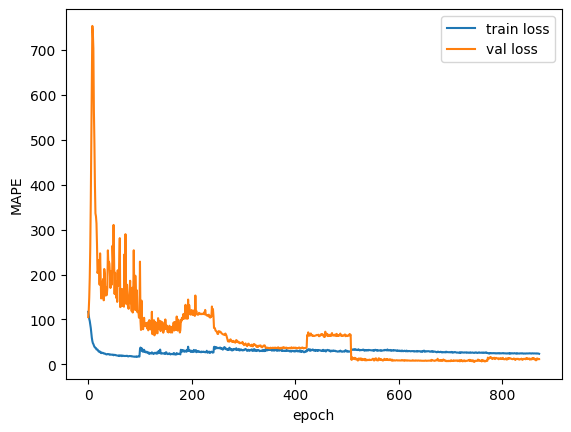

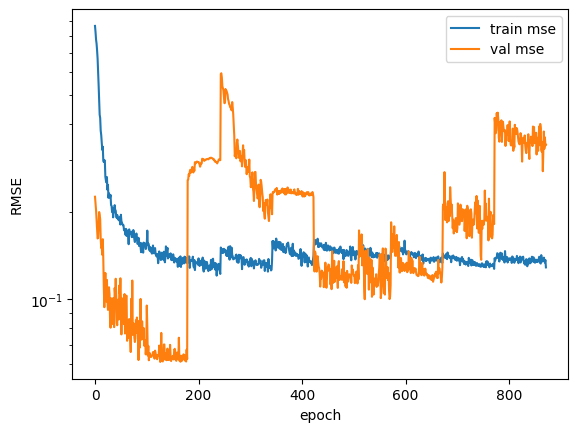

In [48]:
plt.plot(new_hist['loss'])
plt.plot(new_hist['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('epoch')
plt.ylabel('MAPE')
plt.show()
plt.plot(new_hist['root_mean_squared_error'])
plt.plot(new_hist['val_root_mean_squared_error'])
plt.legend(['train mse', 'val mse'])
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.show()

In [37]:
# def plot(model=None, plot_col='Close'):
#         inputs, labels = wide_window.example
#         plot_col_index = wide_window.column_indices[plot_col]
#         for n in range(7):
#             # plt.subplot(max_n, 1, n+1)
#             plt.ylabel(f'{plot_col} [normed]')
#             plt.plot(wide_window.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

#             if wide_window.label_columns:
#                 label_col_index = wide_window.label_columns_indices.get(plot_col, None)
#             else:
#                 label_col_index = plot_col_index

#             if label_col_index is None:
#                 continue

#             plt.scatter(wide_window.label_indices, labels[n, :, label_col_index],
#                         edgecolors='k', label='Labels', c='#2ca02c', s=64)
#             if model is not None:
#                 predictions = model(inputs)
#                 plt.scatter(wide_window.label_indices[-1], predictions[n],
#                           marker='X', edgecolors='k', label='Predictions',
#                           c='#ff7f0e', s=64)
#             plt.legend()
#             plt.show()

## Experiments

In [147]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50, min_delta=0.1, restore_best_weights=True, start_from_epoch=10)]

In [27]:
wide_window = WindowGenerator(input_width=7, label_width=7, shift=1,
                     label_columns=['Close'])
input_shape = wide_window.example[0].shape[1:]

In [60]:
tscv = TimeSeriesSplit(n_splits=10, test_size=71)

#### Model 2
- train_loss: 17.6%
- train_rmse: 0.16
- val_loss: 17.5%
- val_rmse: 0.25

In [29]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [30]:
history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=7, label_width=7, shift=1,
                     label_columns=['Close'])
    history= model.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    
new_hist = merge_histories(history_all)

Epoch 1/100
22/22 [==============================] - 6s 44ms/step - loss: 113.0828 - root_mean_squared_error: 0.8469 - val_loss: 155.4221 - val_root_mean_squared_error: 0.2418
Epoch 2/100
22/22 [==============================] - 1s 25ms/step - loss: 106.8561 - root_mean_squared_error: 0.8068 - val_loss: 135.4507 - val_root_mean_squared_error: 0.2324
Epoch 3/100
22/22 [==============================] - 1s 27ms/step - loss: 102.9084 - root_mean_squared_error: 0.7943 - val_loss: 129.9646 - val_root_mean_squared_error: 0.2255
Epoch 4/100
22/22 [==============================] - 1s 30ms/step - loss: 100.6210 - root_mean_squared_error: 0.7777 - val_loss: 131.4775 - val_root_mean_squared_error: 0.2206
Epoch 5/100
22/22 [==============================] - 1s 25ms/step - loss: 98.1200 - root_mean_squared_error: 0.7729 - val_loss: 142.8412 - val_root_mean_squared_error: 0.2165
Epoch 6/100
22/22 [==============================] - 1s 26ms/step - loss: 96.5248 - root_mean_squared_error: 0.7628 - val

In [31]:
model.save(models_dir + 'model_cval_2.h5')

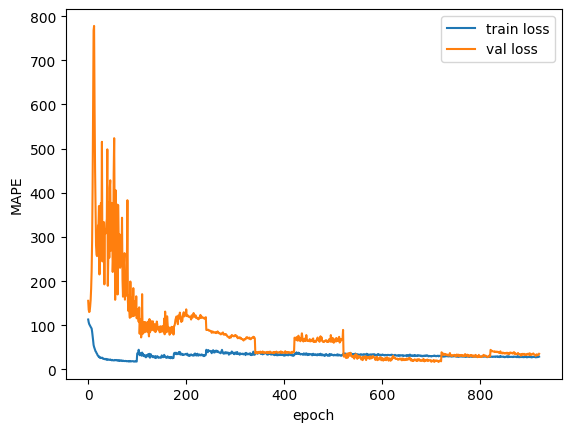

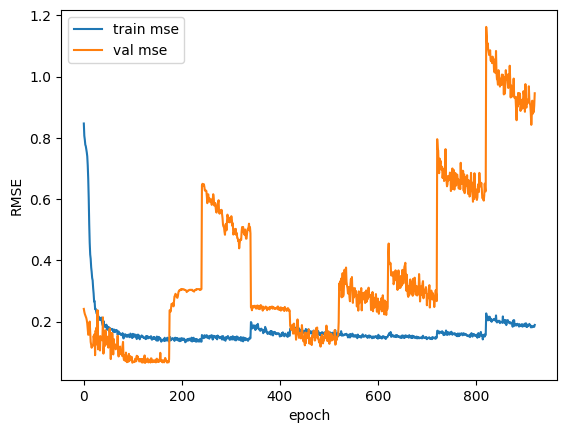

In [34]:
plt.plot(new_hist['loss'])
plt.plot(new_hist['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('epoch')
plt.ylabel('MAPE')
plt.show()
plt.plot(new_hist['root_mean_squared_error'])
plt.plot(new_hist['val_root_mean_squared_error'])
plt.legend(['train mse', 'val mse'])
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.show()

In [44]:
def plot_metrics(hist):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(hist['loss'])
    ax[0].plot(hist['val_loss'])
    ax[0].legend(['train loss', 'val loss'])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MAPE')
    ax[1].plot(hist['root_mean_squared_error'])
    ax[1].plot(hist['val_root_mean_squared_error'])
    ax[1].legend(['train mse', 'val mse'])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('RMSE')
    plt.show()

### Models with 2 week window

In [35]:
wide_window = WindowGenerator(input_width=14, label_width=14, shift=1,
                     label_columns=['Close'])
input_shape = wide_window.example[0].shape[1:]

#### Model 3
- train_loss: 29%
- train_rmse: 0.17
- val_loss: 12%
- val_rmse: 0.27

Epoch 1/100
22/22 [==============================] - 7s 89ms/step - loss: 174.7901 - root_mean_squared_error: 1.2537 - val_loss: 977.1440 - val_root_mean_squared_error: 0.4082
Epoch 2/100
22/22 [==============================] - 1s 66ms/step - loss: 152.8464 - root_mean_squared_error: 1.0428 - val_loss: 766.5948 - val_root_mean_squared_error: 0.3639
Epoch 3/100
22/22 [==============================] - 1s 67ms/step - loss: 144.1477 - root_mean_squared_error: 1.0006 - val_loss: 584.5726 - val_root_mean_squared_error: 0.3310
Epoch 4/100
22/22 [==============================] - 2s 70ms/step - loss: 136.7150 - root_mean_squared_error: 0.9757 - val_loss: 516.4909 - val_root_mean_squared_error: 0.3168
Epoch 5/100
22/22 [==============================] - 1s 67ms/step - loss: 131.7658 - root_mean_squared_error: 0.9485 - val_loss: 455.8878 - val_root_mean_squared_error: 0.2974
Epoch 6/100
22/22 [==============================] - 1s 67ms/step - loss: 127.4870 - root_mean_squared_error: 0.9225 - v

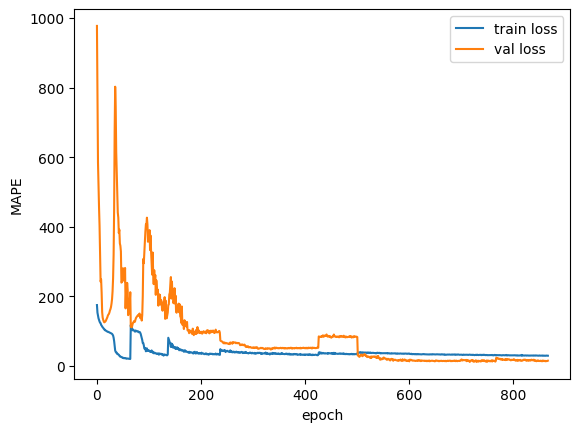

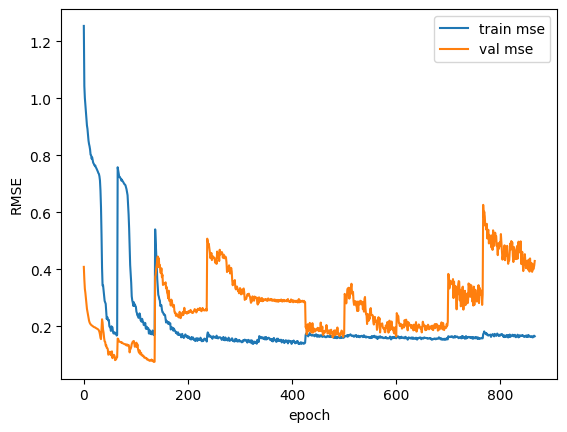

In [37]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=14, label_width=14, shift=1,
                     label_columns=['Close'])
    history= model.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    
new_hist = merge_histories(history_all)

model.save(models_dir + 'model_cval_2weeks.h5')

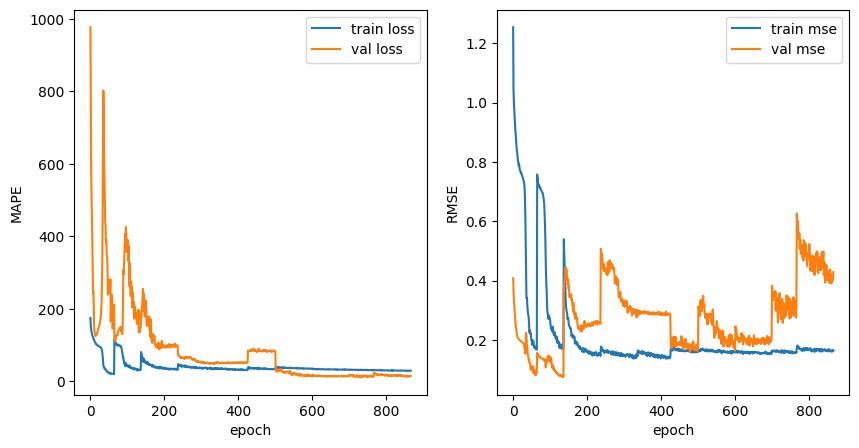

In [45]:
plot_metrics(new_hist)

#### Model 4
bigger head_size
- train_loss: 30%
- train_rmse: 0.15
- val_loss: 6.4%
- val_rmse: 0.15

In [46]:
model2 = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model2.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=14, label_width=14, shift=1,
                     label_columns=['Close'])
    history= model2.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    
new_hist = merge_histories(history_all)

model2.save(models_dir + 'model_cval_2weeks_2.h5')

Epoch 1/100
22/22 [==============================] - 9s 148ms/step - loss: 107.0851 - root_mean_squared_error: 0.8295 - val_loss: 198.0174 - val_root_mean_squared_error: 0.2030
Epoch 2/100
22/22 [==============================] - 3s 130ms/step - loss: 98.0666 - root_mean_squared_error: 0.7723 - val_loss: 153.6508 - val_root_mean_squared_error: 0.1805
Epoch 3/100
22/22 [==============================] - 3s 135ms/step - loss: 86.1505 - root_mean_squared_error: 0.7059 - val_loss: 214.4455 - val_root_mean_squared_error: 0.1566
Epoch 4/100
22/22 [==============================] - 3s 133ms/step - loss: 74.5864 - root_mean_squared_error: 0.6323 - val_loss: 328.9471 - val_root_mean_squared_error: 0.1346
Epoch 5/100
22/22 [==============================] - 3s 133ms/step - loss: 59.8699 - root_mean_squared_error: 0.5488 - val_loss: 450.5791 - val_root_mean_squared_error: 0.1316
Epoch 6/100
22/22 [==============================] - 3s 131ms/step - loss: 50.2170 - root_mean_squared_error: 0.4551 - 

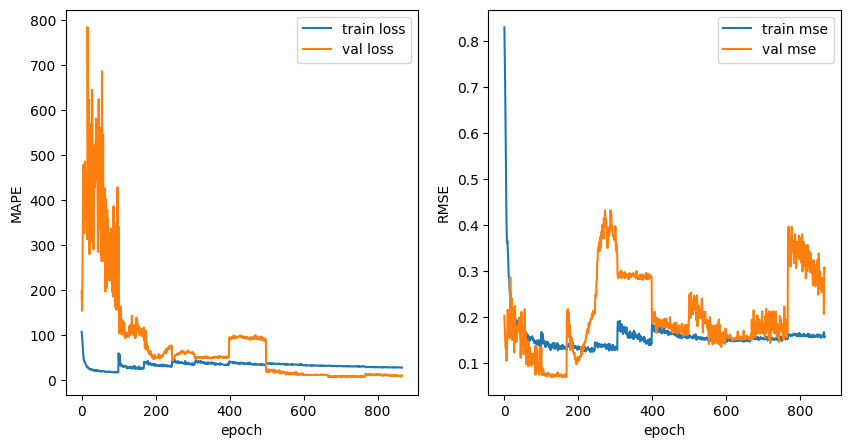

In [47]:
plot_metrics(new_hist)

#### Model 5
5 instead of 4 transformer blocks
- train_loss: 34.3% 
- train_rmse: 0.16
- val_loss: 12%
- val_rmse: 0.16

In [48]:
model3 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=5,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model3.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=14, label_width=14, shift=1,
                     label_columns=['Close'])
    history= model3.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    
new_hist = merge_histories(history_all)

model3.save(models_dir + 'model_cval_2weeks_3.h5')

Epoch 1/100
22/22 [==============================] - 9s 122ms/step - loss: 89.9743 - root_mean_squared_error: 0.7322 - val_loss: 231.5007 - val_root_mean_squared_error: 0.1810
Epoch 2/100
22/22 [==============================] - 2s 100ms/step - loss: 74.4237 - root_mean_squared_error: 0.6617 - val_loss: 336.7650 - val_root_mean_squared_error: 0.1639
Epoch 3/100
22/22 [==============================] - 2s 102ms/step - loss: 61.2372 - root_mean_squared_error: 0.5689 - val_loss: 489.5073 - val_root_mean_squared_error: 0.1620
Epoch 4/100
22/22 [==============================] - 2s 101ms/step - loss: 56.4378 - root_mean_squared_error: 0.4902 - val_loss: 589.1516 - val_root_mean_squared_error: 0.1752
Epoch 5/100
22/22 [==============================] - 2s 103ms/step - loss: 54.4822 - root_mean_squared_error: 0.4505 - val_loss: 615.3210 - val_root_mean_squared_error: 0.1747
Epoch 6/100
22/22 [==============================] - 2s 104ms/step - loss: 51.7392 - root_mean_squared_error: 0.4482 - v

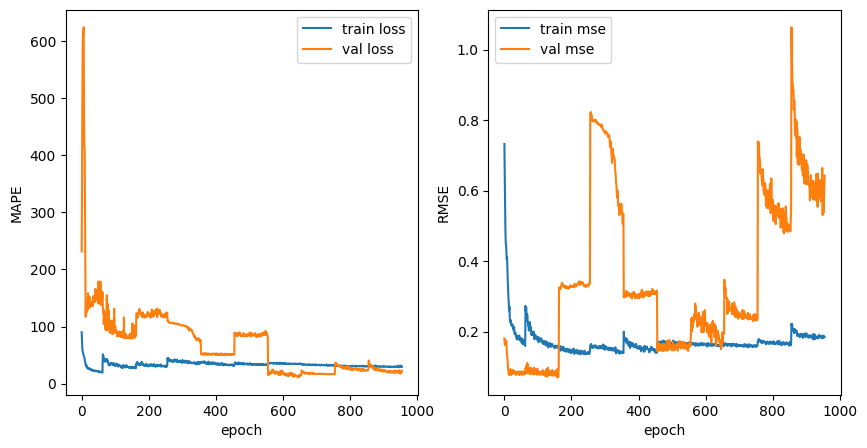

In [49]:
plot_metrics(new_hist)

#### Model 6
6 instead of 4 transformer blocks
- train_loss: 27.5%
- train_rmse: 0.16
- val_loss: 11%
- val_rmse: 0.32

In [50]:
model4 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=6,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model4.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=14, label_width=14, shift=1,
                     label_columns=['Close'])
    history= model4.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    
new_hist = merge_histories(history_all)

model4.save(models_dir + 'model_cval_2weeks_4.h5')

Epoch 1/100
22/22 [==============================] - 11s 136ms/step - loss: 97.5881 - root_mean_squared_error: 0.7731 - val_loss: 192.5749 - val_root_mean_squared_error: 0.1815
Epoch 2/100
22/22 [==============================] - 2s 113ms/step - loss: 91.2335 - root_mean_squared_error: 0.7248 - val_loss: 252.7498 - val_root_mean_squared_error: 0.1671
Epoch 3/100
22/22 [==============================] - 3s 113ms/step - loss: 81.6936 - root_mean_squared_error: 0.6826 - val_loss: 367.9487 - val_root_mean_squared_error: 0.1504
Epoch 4/100
22/22 [==============================] - 2s 112ms/step - loss: 68.4402 - root_mean_squared_error: 0.6011 - val_loss: 545.1807 - val_root_mean_squared_error: 0.1502
Epoch 5/100
22/22 [==============================] - 3s 114ms/step - loss: 52.8045 - root_mean_squared_error: 0.4910 - val_loss: 667.9398 - val_root_mean_squared_error: 0.1657
Epoch 6/100
22/22 [==============================] - 3s 114ms/step - loss: 47.4954 - root_mean_squared_error: 0.4035 - 

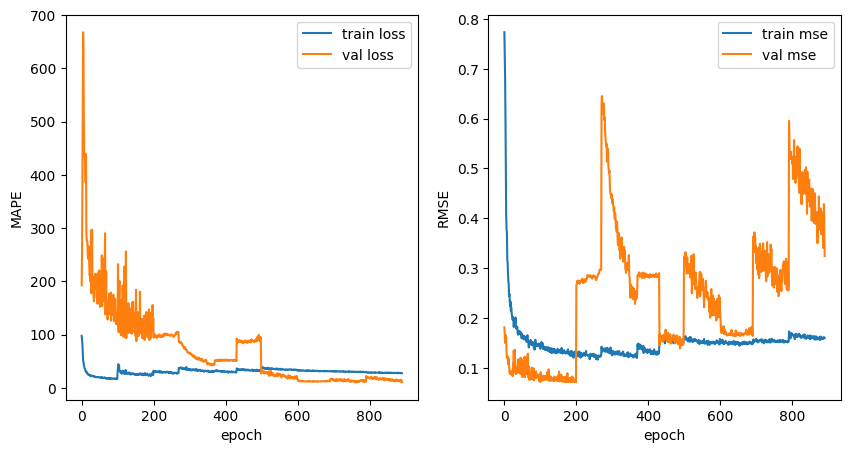

In [51]:
plot_metrics(new_hist)

#### Model 7
bigger head size

6 transformer blocks
- train_loss: 35.6%
- train_rmse: 0.17
- val_loss: 17%
- val_rmse: 0.23

In [52]:
model5 = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=6,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model5.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=14, label_width=14, shift=1,
                     label_columns=['Close'])
    history= model5.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    
new_hist = merge_histories(history_all)

model5.save(models_dir + 'model_cval_2weeks_5.h5')

Epoch 1/100
22/22 [==============================] - 14s 221ms/step - loss: 110.1739 - root_mean_squared_error: 0.8294 - val_loss: 171.3726 - val_root_mean_squared_error: 0.1995
Epoch 2/100
22/22 [==============================] - 4s 192ms/step - loss: 100.2641 - root_mean_squared_error: 0.7860 - val_loss: 191.6880 - val_root_mean_squared_error: 0.1905
Epoch 3/100
22/22 [==============================] - 4s 189ms/step - loss: 95.7665 - root_mean_squared_error: 0.7668 - val_loss: 236.0181 - val_root_mean_squared_error: 0.1817
Epoch 4/100
22/22 [==============================] - 4s 187ms/step - loss: 90.5726 - root_mean_squared_error: 0.7335 - val_loss: 303.3163 - val_root_mean_squared_error: 0.1692
Epoch 5/100
22/22 [==============================] - 4s 189ms/step - loss: 81.0951 - root_mean_squared_error: 0.6860 - val_loss: 449.5766 - val_root_mean_squared_error: 0.1563
Epoch 6/100
22/22 [==============================] - 4s 191ms/step - loss: 70.1001 - root_mean_squared_error: 0.6227 

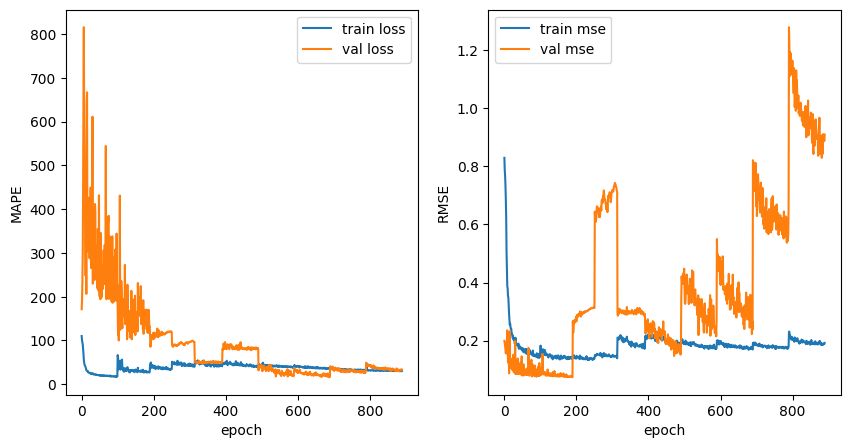

In [53]:
plot_metrics(new_hist)

#### Model 8
bigger head size

5 instead of 4 attention heads
- train_loss: 33.2%
- train_rmse: 0.16
- val_loss: 13%
- val_rmse: 0.17

In [54]:
model6 = build_model(
    input_shape,
    head_size=512,
    num_heads=5,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model6.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=14, label_width=14, shift=1,
                     label_columns=['Close'])
    history= model6.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    
new_hist = merge_histories(history_all)

model6.save(models_dir + 'model_cval_2weeks_6.h5')

Epoch 1/100
22/22 [==============================] - 9s 174ms/step - loss: 111.5273 - root_mean_squared_error: 0.8388 - val_loss: 196.1777 - val_root_mean_squared_error: 0.2211
Epoch 2/100
22/22 [==============================] - 3s 153ms/step - loss: 105.0738 - root_mean_squared_error: 0.8023 - val_loss: 176.4333 - val_root_mean_squared_error: 0.1947
Epoch 3/100
22/22 [==============================] - 3s 152ms/step - loss: 99.0725 - root_mean_squared_error: 0.7762 - val_loss: 284.2514 - val_root_mean_squared_error: 0.1730
Epoch 4/100
22/22 [==============================] - 3s 153ms/step - loss: 87.2962 - root_mean_squared_error: 0.7259 - val_loss: 502.1922 - val_root_mean_squared_error: 0.1575
Epoch 5/100
22/22 [==============================] - 3s 153ms/step - loss: 68.7211 - root_mean_squared_error: 0.6111 - val_loss: 855.7082 - val_root_mean_squared_error: 0.2063
Epoch 6/100
22/22 [==============================] - 3s 152ms/step - loss: 53.1972 - root_mean_squared_error: 0.4819 -

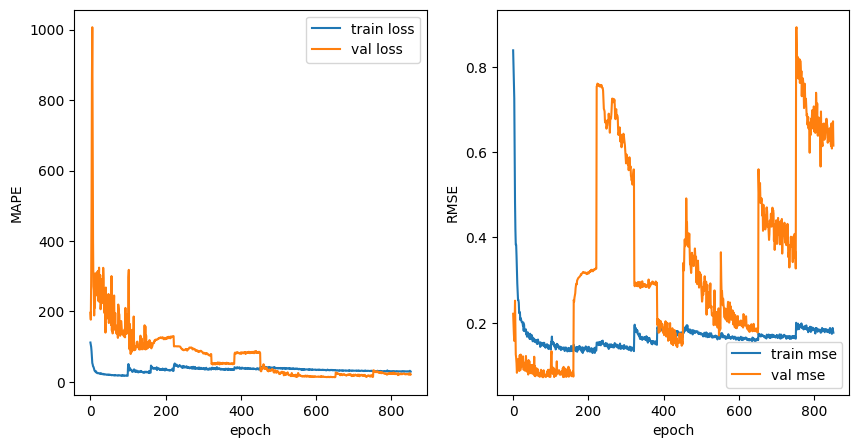

In [55]:
plot_metrics(new_hist)

#### Model 9
bigger head size

less attention heads
- train_loss: 32%
- train_rmse: 0.15
- val_loss: 16.7%
- val_rmse: 0.23

In [56]:
model7 = build_model(
    input_shape,
    head_size=512,
    num_heads=3,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model7.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],val_df=train_df.iloc[test_index], input_width=14, label_width=14, shift=1,
                     label_columns=['Close'])
    history= model7.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    
new_hist = merge_histories(history_all)

model7.save(models_dir + 'model_cval_2weeks_7.h5')

Epoch 1/100
22/22 [==============================] - 13s 137ms/step - loss: 107.8253 - root_mean_squared_error: 0.8352 - val_loss: 116.4422 - val_root_mean_squared_error: 0.2016
Epoch 2/100
22/22 [==============================] - 2s 101ms/step - loss: 99.7484 - root_mean_squared_error: 0.7889 - val_loss: 127.4031 - val_root_mean_squared_error: 0.1994
Epoch 3/100
22/22 [==============================] - 2s 100ms/step - loss: 94.3328 - root_mean_squared_error: 0.7518 - val_loss: 134.5722 - val_root_mean_squared_error: 0.1975
Epoch 4/100
22/22 [==============================] - 2s 100ms/step - loss: 86.3719 - root_mean_squared_error: 0.7142 - val_loss: 137.1622 - val_root_mean_squared_error: 0.1816
Epoch 5/100
22/22 [==============================] - 2s 103ms/step - loss: 73.5091 - root_mean_squared_error: 0.6445 - val_loss: 147.7826 - val_root_mean_squared_error: 0.1447
Epoch 6/100
22/22 [==============================] - 2s 101ms/step - loss: 56.9946 - root_mean_squared_error: 0.5243 -

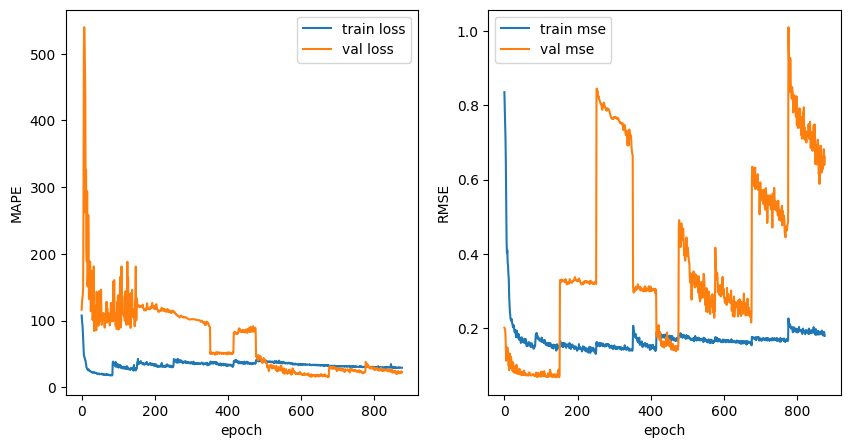

In [57]:
plot_metrics(new_hist)

### Models with 2 month window and 10k datapoints

#### New data split

In [68]:
n = len(df)
train_df = df[0:int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
input_width_ = 60
label_width_ = 60

In [69]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [73]:
wide_window = WindowGenerator(train_df=train_df,
                              val_df=test_df,
                              input_width=input_width_, 
                              label_width=label_width_, 
                              shift=1,
                              label_columns=['Close'])
input_shape = wide_window.example[0].shape[1:]

#### Writing custom metric - Symmetric MAPE

In [145]:
def sMAPE(y_true, y_pred):
    difference = 2* tf.abs(y_pred-y_true)
    abs_sum = tf.abs(y_true) + tf.abs(y_pred)
    division = difference/abs_sum
    return 100* tf.reduce_mean(division, axis=-1)

#### Model 10

In [95]:
model10 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model10.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), sMAPE],
)

history_all = []
for i, (train_index, test_index) in enumerate(tscv.split(train_df)):
    wide_window = WindowGenerator(train_df=train_df.iloc[train_index],
                                  val_df=train_df.iloc[test_index], 
                                  input_width=input_width_, 
                                  label_width=label_width_, 
                                  shift=1,
                                  label_columns=['Close'])
    history= model10.fit(
        wide_window.train,
        epochs=100,
        callbacks=callbacks,
        validation_data=wide_window.val,
        verbose=1)
    history_all.append(history)
    model10.save(models_dir + 'model_cval_2months_2.h5')
    
new_hist = merge_histories(history_all)

model10.save(models_dir + 'model_cval_2months_2.h5')

Epoch 1/100
258/258 [==============================] - 124s 459ms/step - loss: 155.0780 - root_mean_squared_error: 0.8332 - sMAPE: 162.4527 - val_loss: 106.5894 - val_root_mean_squared_error: 2.1686 - val_sMAPE: 200.0000
Epoch 2/100
258/258 [==============================] - 115s 446ms/step - loss: 137.3795 - root_mean_squared_error: 0.7855 - sMAPE: 158.9685 - val_loss: 103.0532 - val_root_mean_squared_error: 2.0968 - val_sMAPE: 200.0000
Epoch 3/100
258/258 [==============================] - 114s 443ms/step - loss: 124.0079 - root_mean_squared_error: 0.7111 - sMAPE: 136.3949 - val_loss: 96.8728 - val_root_mean_squared_error: 1.9722 - val_sMAPE: 187.6248
Epoch 4/100
258/258 [==============================] - 124s 482ms/step - loss: 92.1958 - root_mean_squared_error: 0.4917 - sMAPE: 75.8885 - val_loss: 51.5242 - val_root_mean_squared_error: 1.0528 - val_sMAPE: 69.5182
Epoch 5/100
258/258 [==============================] - 169s 655ms/step - loss: 81.5371 - root_mean_squared_error: 0.3978 

KeyboardInterrupt: 

In [ ]:
wide_window = WindowGenerator(train_df=train_df,
                              val_df=test_df,
                              test_df=test_df
                              input_width=input_width_, 
                              label_width=label_width_, 
                              shift=1,
                              label_columns=['Close'])

In [97]:
model10.evaluate(wide_window.test, verbose=1)

30/30 [==============================] - 5s 149ms/step - loss: 80.6023 - root_mean_squared_error: 8.0646 - sMAPE: 136.2917


[80.6022720336914, 8.064642906188965, 136.29168701171875]

## New training approach

In [162]:
input_shape = train_X.shape[1:]

In [164]:
model_new_1 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_new_1.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), sMAPE],
)

history= model_new_1.fit(x=train_X, 
                     y=train_y,
                     epochs=100,
                     callbacks=callbacks,
                     validation_data=(val_X, val_y),
                     verbose=1)

model_new_1.save(models_dir + 'model_new_1.h5')

Epoch 1/100
218/218 [==============================] - 81s 348ms/step - loss: 115.2844 - root_mean_squared_error: 0.5898 - sMAPE: 134.3438 - val_loss: 64.7843 - val_root_mean_squared_error: 0.4360 - val_sMAPE: 83.8398
Epoch 2/100
218/218 [==============================] - 77s 355ms/step - loss: 67.8968 - root_mean_squared_error: 0.3972 - sMAPE: 72.6208 - val_loss: 41.6903 - val_root_mean_squared_error: 0.2655 - val_sMAPE: 41.2003
Epoch 3/100
218/218 [==============================] - 75s 343ms/step - loss: 61.0378 - root_mean_squared_error: 0.3552 - sMAPE: 61.8735 - val_loss: 35.9026 - val_root_mean_squared_error: 0.2360 - val_sMAPE: 36.7424
Epoch 4/100
218/218 [==============================] - 78s 359ms/step - loss: 55.9427 - root_mean_squared_error: 0.3374 - sMAPE: 57.7926 - val_loss: 37.2090 - val_root_mean_squared_error: 0.2041 - val_sMAPE: 34.7444
Epoch 5/100
218/218 [==============================] - 71s 327ms/step - loss: 49.8039 - root_mean_squared_error: 0.3008 - sMAPE: 50.31

In [165]:
val_performance = model_new_1.evaluate(val_X, val_y)
performance = model_new_1.evaluate(test_X, test_y)
print("Val loss:", val_performance)
print("Test loss:", performance)

32/32 [==============================] - 4s 115ms/step - loss: 10.2357 - root_mean_squared_error: 0.0563 - sMAPE: 10.8884
Val loss: [10.117457389831543, 0.056339237838983536, 10.829755783081055]
Test loss: [10.235652923583984, 0.05634346604347229, 10.888391494750977]


In [166]:
model_new_2 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_new_2.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), sMAPE],
)

history2= model_new_2.fit(x=train_X, 
                     y=train_y,
                     epochs=500,
                     callbacks=callbacks,
                     validation_data=(val_X, val_y),
                     verbose=1)

model_new_2.save(models_dir + 'model_new_2.h5')

Epoch 1/500
218/218 [==============================] - 81s 347ms/step - loss: 84.5487 - root_mean_squared_error: 0.4012 - sMAPE: 84.5060 - val_loss: 42.0750 - val_root_mean_squared_error: 0.1631 - val_sMAPE: 42.1820
Epoch 2/500
218/218 [==============================] - 74s 342ms/step - loss: 52.0409 - root_mean_squared_error: 0.3048 - sMAPE: 52.3590 - val_loss: 32.8102 - val_root_mean_squared_error: 0.1309 - val_sMAPE: 33.5699
Epoch 3/500
218/218 [==============================] - 74s 341ms/step - loss: 47.7950 - root_mean_squared_error: 0.2859 - sMAPE: 46.7638 - val_loss: 39.8067 - val_root_mean_squared_error: 0.1420 - val_sMAPE: 38.3779
Epoch 4/500
218/218 [==============================] - 74s 341ms/step - loss: 44.2502 - root_mean_squared_error: 0.2609 - sMAPE: 43.7983 - val_loss: 30.5753 - val_root_mean_squared_error: 0.1191 - val_sMAPE: 30.8073
Epoch 5/500
218/218 [==============================] - 74s 341ms/step - loss: 40.1260 - root_mean_squared_error: 0.2383 - sMAPE: 40.9109

In [167]:
val_performance = model_new_2.evaluate(val_X, val_y)
performance = model_new_2.evaluate(test_X, test_y)
print("Val loss:", val_performance)
print("Test loss:", performance)

32/32 [==============================] - 4s 128ms/step - loss: 5.0511 - root_mean_squared_error: 0.0303 - sMAPE: 5.1268
Val loss: [5.019989013671875, 0.02936484105885029, 5.183465003967285]
Test loss: [5.051069259643555, 0.030280273407697678, 5.126842975616455]


In [174]:
val_pred = model_new_2.predict(val_X)
test_pred = model_new_2.predict(test_X)
train_pred = model_new_2.predict(train_X)

218/218 [==============================] - 26s 119ms/step


In [184]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

train_rmse = history2.history['root_mean_squared_error']
val_rmse = history2.history['val_root_mean_squared_error']

train_smape = history2.history['sMAPE']
val_smape = history2.history['val_sMAPE']

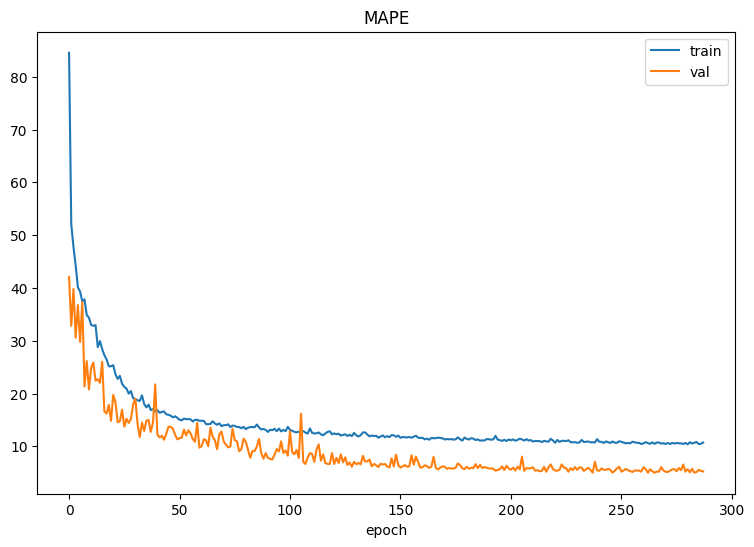

In [206]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('MAPE')
plt.legend(['train','val'])
plt.xlabel('epoch')
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.show()

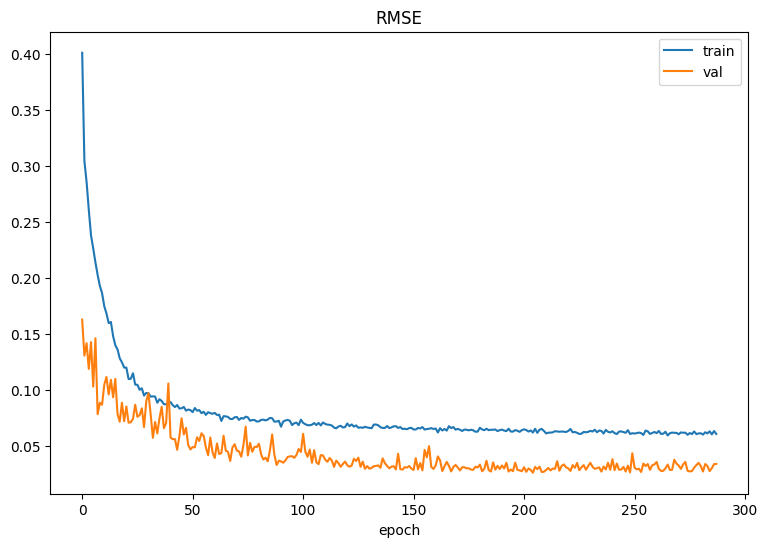

In [207]:
plt.plot(train_rmse)
plt.plot(val_rmse)
plt.title('RMSE')
plt.legend(['train','val'])
plt.xlabel('epoch')
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.show()

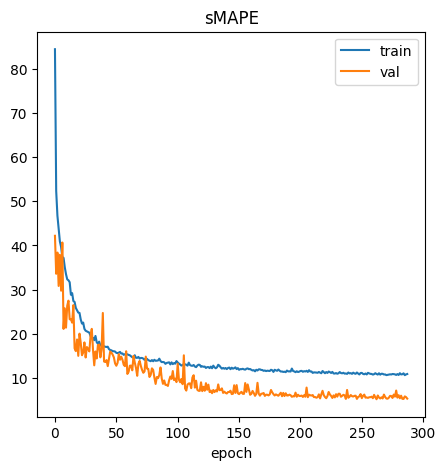

In [205]:
plt.plot(train_smape)
plt.plot(val_smape)
plt.title('sMAPE')
plt.legend(['train','val'])
plt.xlabel('epoch')
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.show()

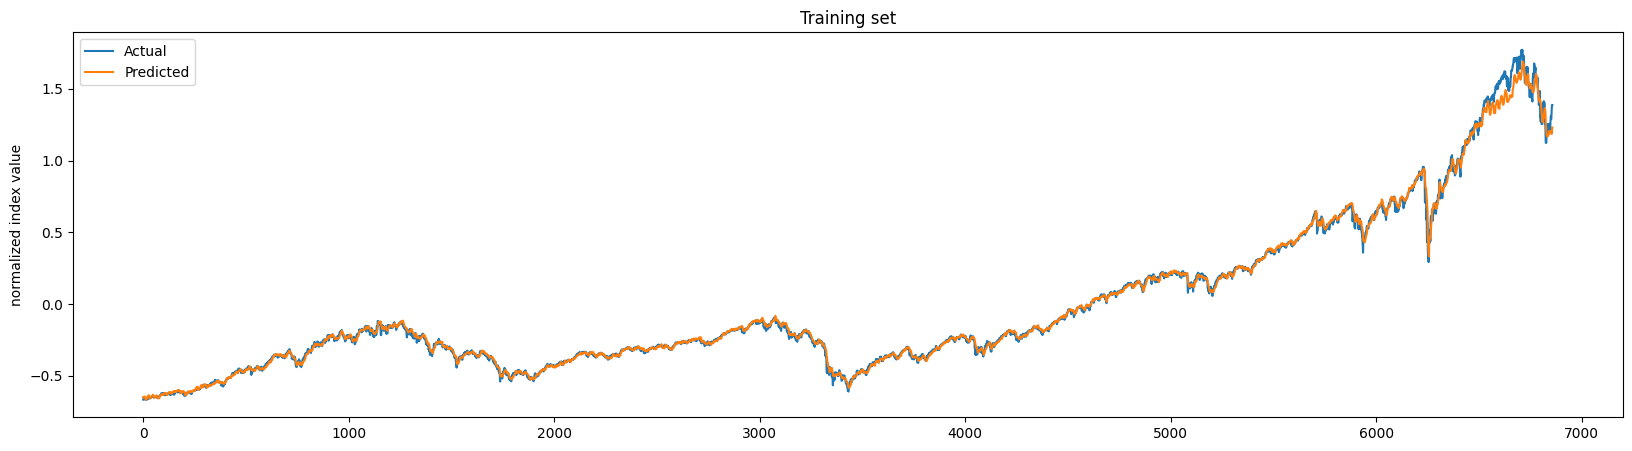

In [192]:
plt.plot(train_y[:-100])
plt.plot(train_pred[:-100])
plt.ylabel('normalized index value')
plt.title('Training set')
plt.legend(['Actual', 'Predicted'])
plt.show()

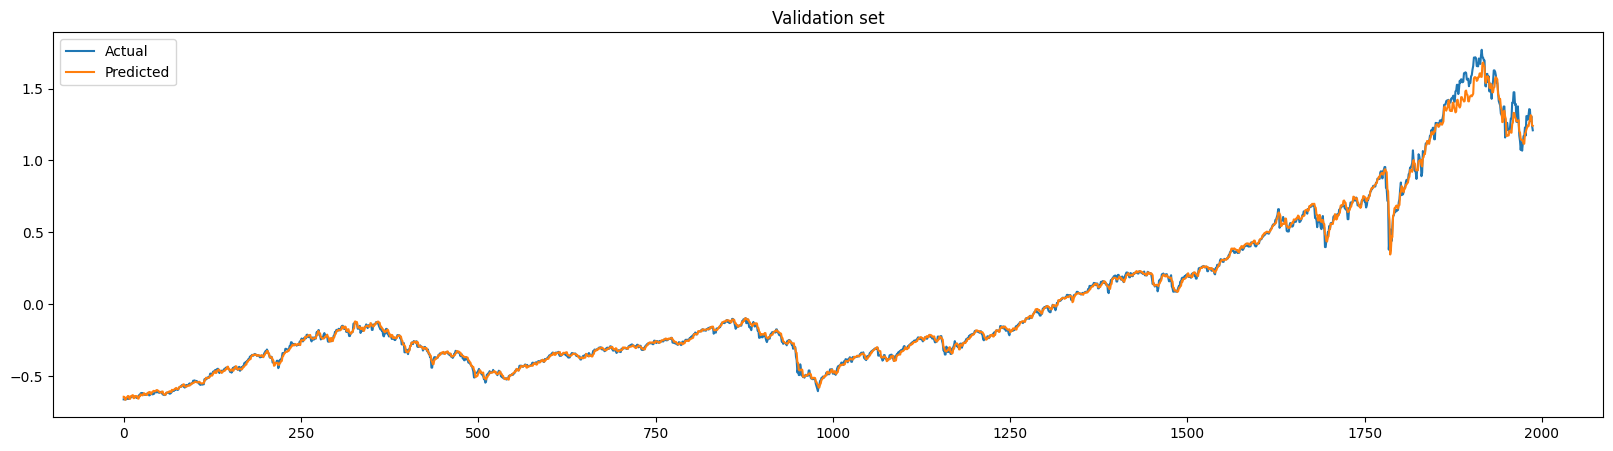

In [179]:
plt.plot(val_y)
plt.plot(val_pred)
plt.title('Validation set')
plt.legend(['Actual', 'Predicted'])
plt.show()

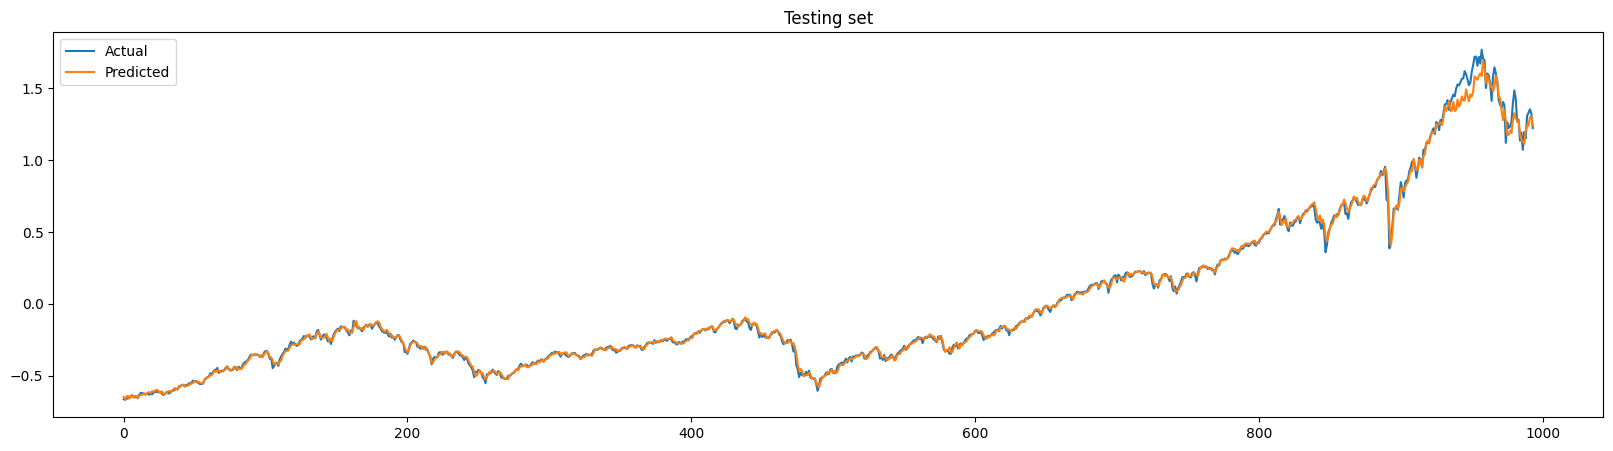

In [180]:
plt.plot(test_y)
plt.plot(test_pred)
plt.title('Testing set')
plt.legend(['Actual', 'Predicted'])
plt.show()